# Exploration Of Lead Time Dynamics

In this notebook I will explore answers to questions that have bothered me in my software delivery role: 
* If team reduces cycle time by 1 day:
    * How will that impact overall lead time?
    * How much more work will team be able to deliver?
    * What will be the lead time for ad hoc requests?
* If team loads less amount of work during a Sprint:
    * How will that impact overall lead time?
    * What will be the lead time for ad hoc requests?
* Team just had an amazing/terrible Sprint does that mean team is improving/regressing?
* How would an "ideal" Sprint look like?



### Data Load 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import leadtimedynamics as ltdy

In [2]:
sprints = pd.read_csv("sprintTeam.csv")
display(sprints.head())

,Sprint,CycleTime,LeadTime
0,A,1,4
1,A,3,10
2,A,6,10
3,A,0,10
4,A,4,10


array([[<AxesSubplot:title={'center':'CycleTime'}>,
        <AxesSubplot:title={'center':'LeadTime'}>]], dtype=object)

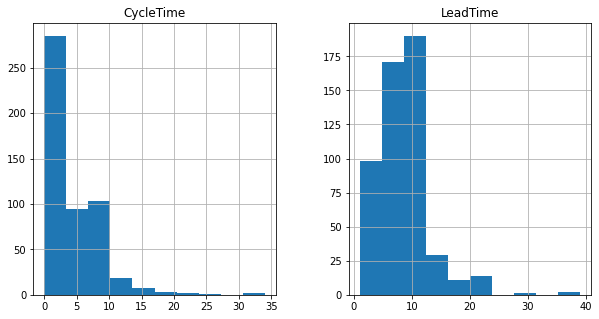

In [3]:
sprints.hist(bins=10, figsize=(10,5))

In [4]:
sprints.describe()

,CycleTime,LeadTime
count,516.000000,516.000000
mean,4.449612,8.447674
std,4.315178,4.520415
min,0.000000,1.000000
25%,1.000000,6.000000
50%,3.000000,8.000000
75%,7.000000,10.000000
max,34.000000,39.000000


In [5]:
sprint_cycletime_z = np.abs(stats.zscore(sprints["CycleTime"]))
sprint_leadtime_z = np.abs(stats.zscore(sprints["LeadTime"]))

sprint_clean = sprints.copy(deep=True)
sprint_clean["CycleTime"] = sprint_clean["CycleTime"][np.where(sprint_cycletime_z < 3)[0]]
sprint_clean["LeadTime"] = sprint_clean["LeadTime"][np.where(sprint_leadtime_z < 3)[0]]

sprint_clean.dropna(inplace=True)

sprint_clean["CycleTime"] = sprint_clean["CycleTime"].astype(int)
sprint_clean["LeadTime"] = sprint_clean["LeadTime"].astype(int)
sprint_clean_simple = sprint_clean[["CycleTime","LeadTime"]]

print("Original data length: {0}, cleaned length: {1}".format(len(sprints), len(sprint_clean)))

Original data length: 516, cleaned length: 505


array([[<AxesSubplot:title={'center':'CycleTime'}>,
        <AxesSubplot:title={'center':'LeadTime'}>]], dtype=object)

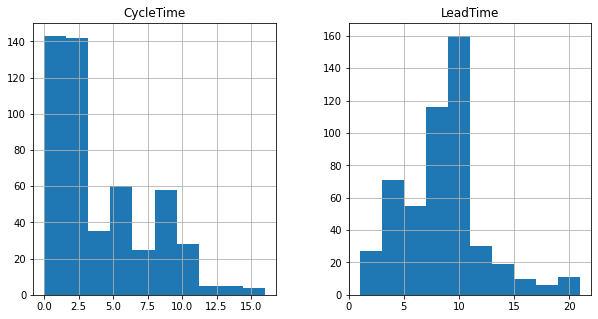

In [6]:
sprint_clean.hist(bins=10, figsize=(10,5))

Number of work items per Sprint mean: 19, std: Count    5.832139
dtype: float64


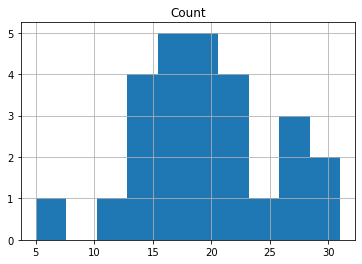

In [7]:
sprint_clean_workitem_count = sprint_clean.groupby('Sprint').agg(Count =('Sprint', 'count'))
sprint_clean_workitem_count = sprint_clean_workitem_count.reset_index()
sprint_clean_workitem_count_mean = sprint_clean_workitem_count.mean().Count.astype(int)
sprint_clean_workitem_count_std = sprint_clean_workitem_count.std()
sprint_clean_workitem_count.hist()

print("Number of work items per Sprint mean: {0}, std: {1}".format(sprint_clean_workitem_count_mean, sprint_clean_workitem_count_std))

### Visualisation of existing lead time and cycle time distribution 


<AxesSubplot:xlabel='LeadTime'>

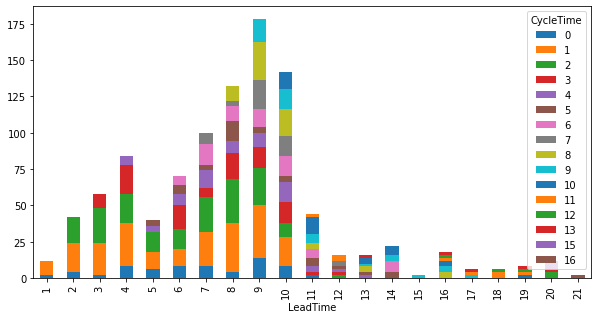

In [8]:
sprint_cycletime_p = pd.pivot_table(sprint_clean_simple, values='CycleTime', index=['CycleTime'],
                    columns=['LeadTime'], aggfunc=np.size, fill_value=0)

sprint_cycletime_p.T.plot(kind="bar", stacked=True, figsize=(10,5))

Below each cycle time and lead time event will be turned in to an event with a probability. Later on this will be used to run Monte Carlo simulation.

In [9]:
sprint_cycletime_labels = sprint_cycletime_p.index
sprint_workitems_delivered_perday = np.dot(np.full((len(sprint_cycletime_p.index),len(sprint_cycletime_p.index)), 1), sprint_cycletime_p.values)
sprint_workitems_delivered_perday_cycle_ratio = sprint_cycletime_p.values / sprint_workitems_delivered_perday

In [10]:
sprint_clean_leadtime_count = sprint_clean.groupby('LeadTime').agg(Count =('LeadTime', 'count'))
sprint_leadtime_labels = sprint_clean_leadtime_count.index.astype(int)
sprint_workitems_delivered_perday_total_ratio = (sprint_clean_leadtime_count / sprint_clean_leadtime_count.sum()).values.T[0]


In [11]:
sprint_perday_cycle_ratio = (sprint_workitems_delivered_perday_cycle_ratio * sprint_workitems_delivered_perday_total_ratio).T

sprint_clean_combinations, sprint_clean_combinations_p = ltdy.combination_matrix_to_array(sprint_perday_cycle_ratio, sprint_leadtime_labels, sprint_cycletime_labels)


### Cycle time reduction  
To simulate cycle time reduction by 1 day, two steps will need to be performed: 
1. All work needs to be reduced by 1-day average
2. Space created due to reduction needs to be filled with work.

#### 1. Reduce 
Now we are going to reduce the work items by 1 day average.


<AxesSubplot:xlabel='LeadTime'>

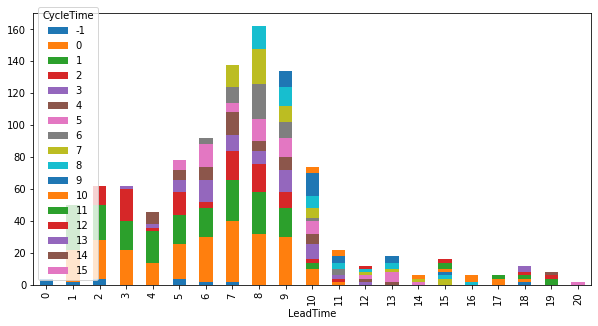

In [12]:
sprint_reduced = sprint_clean_simple.copy(deep=True)
sprint_reduced = ltdy.reduce(sprint_reduced)

sprint_reduced_cycletime_p = pd.pivot_table(sprint_reduced, values='CycleTime', index=['CycleTime'], columns=['LeadTime'], aggfunc=np.size, fill_value=0)
sprint_reduced_cycletime_p.T.plot(kind="bar", stacked=True, figsize=(10,5))


#### 2. Shift left
Now that work was reduced by 1-day average we will:
* Identify how many work items were being done at the same time per day originally 
* Identify the difference between how much was being done and is being done now
* Shift work into the available space that was created by the reduction

But before that is done, let's see the space that was created:


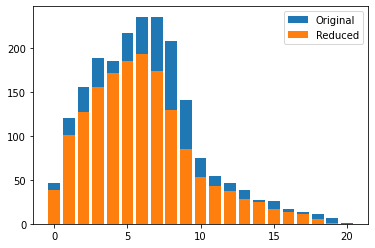

> Space created: [ 38 101 127 156 172 186 193 174 130  85  53  43  37  28  25  17  14  11
   5   1   0]


In [13]:
original_leadtime_sum, original_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(sprint_clean_simple.values))
reduced_leadtime_sum, reduced_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(sprint_reduced.values))
space = ltdy.array_normalise_size(original_leadtime_sum, reduced_leadtime_sum)

bar_original = plt.bar(original_leadtime_sum_labels,original_leadtime_sum)
bar_reduced = plt.bar(reduced_leadtime_sum_labels,reduced_leadtime_sum)

plt.legend((bar_original, bar_reduced), ('Original', 'Reduced'))
plt.show()
print("> Space created:", space)

In [14]:

original_leadtime_sum, original_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(sprint_clean_simple.values))

shifted = None
shifted_total = 0
workitems_shifted = copy.deepcopy(sprint_reduced.values)
iterations = 0
while shifted == None or shifted > 0:
    empty_blocks = []
    shifted_leadtime_sum, shifted_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(workitems_shifted))
    shifted_leadtime_sum = ltdy.array_normalise_size(original_leadtime_sum, shifted_leadtime_sum)
    empty_space = original_leadtime_sum - shifted_leadtime_sum
    ltdy.create_blocks(empty_space, 0, len(empty_space), empty_blocks)
    workitems_to_shift_by_1_day = np.array(empty_blocks)+[0, 1]
    workitem_hash = ltdy.array_to_hash(workitems_shifted)
    shifted = ltdy.shift_left(workitem_hash, workitems_to_shift_by_1_day)
    shifted_total += shifted
    workitems_shifted = ltdy.hash_to_array(workitem_hash)
    iterations += 1
    
print("> Number of iterations: {0}, shifted: {1} work items".format(iterations, shifted_total))


> Number of iterations: 14, shifted: 171 work items


#### Shift efficiency review

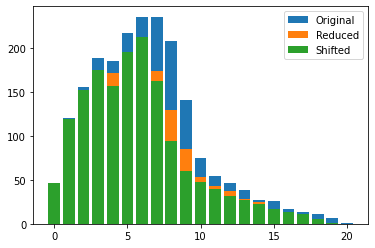

In [15]:

shifted_leadtime_sum, shifted_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(workitems_shifted))

bar_original = plt.bar(original_leadtime_sum_labels,original_leadtime_sum)
bar_reduced = plt.bar(reduced_leadtime_sum_labels,reduced_leadtime_sum)
bar_shifted = plt.bar(shifted_leadtime_sum_labels,shifted_leadtime_sum)

plt.legend((bar_original, bar_reduced, bar_shifted), ('Original', 'Reduced', 'Shifted'))
plt.show()


### Q: If team reduces cycle time by 1 day, how will that impact overall lead time?
### A:
Below you can see the lead time profile change when cycle time is reduced by 1-day average across all work.


<AxesSubplot:xlabel='LeadTime'>

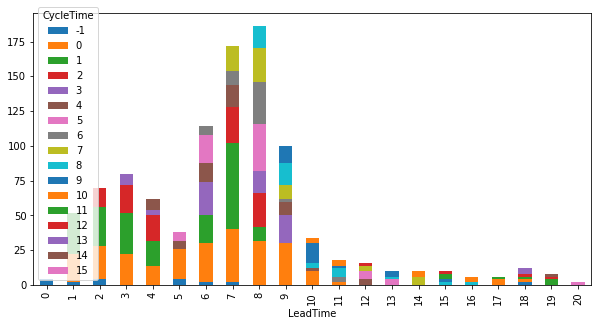

In [16]:
sprint_shifted_cycletime_p = pd.pivot_table(pd.DataFrame(workitems_shifted, columns=['CycleTime', 'LeadTime']), values='CycleTime', index=['CycleTime'], columns=['LeadTime'], aggfunc=np.size, fill_value=0)
sprint_shifted_cycletime_p.T.plot(kind="bar", stacked=True, figsize=(10,5))


In [17]:
print("> Amount of work delivered originally: {0}, after shift left: {1}".format(len(sprint_clean_simple), len(workitems_shifted)))


> Amount of work delivered originally: 505, after shift left: 505


It is important to note that amount of work before and after that is being done is still the same. However, if we take a look at the "shift efficiency review" we will see that there are plenty of space (blue). Let's see how much work we can "pack" into this space.

### Q: If team reduces cycle time by 1 day, how much more work will team be able to deliver?
### A:

In [18]:

shifted_leadtime_sum, shifted_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(workitems_shifted))
shifted_leadtime_sum = ltdy.array_normalise_size(original_leadtime_sum, shifted_leadtime_sum)
empty_space = original_leadtime_sum - shifted_leadtime_sum
empty_blocks = []
ltdy.create_blocks(empty_space, 0, len(empty_space), empty_blocks)
print("> After shift left it is possible to deliver additional: {0} work items, per Sprint this will yield ~{1:.2%} increase.".format(len(empty_blocks), len(empty_blocks) / len(workitems_shifted) ))


> After shift left it is possible to deliver additional: 176 work items, per Sprint this will yield ~34.85% increase.


This additional work will change the profile of the lead time, here is how it will look like now:


> Amount of work delivered originally: 505, after shift left and packing: 681


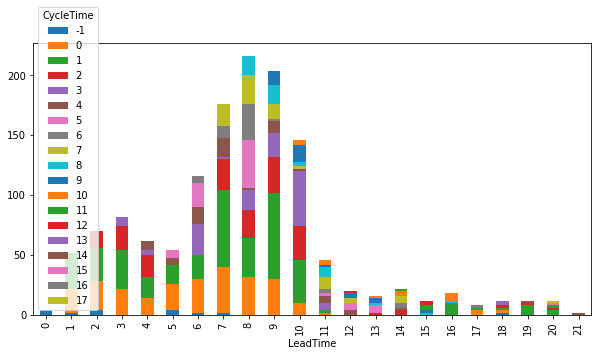

In [19]:

workitems_shifted_packed = copy.deepcopy(workitems_shifted)
workitem_hash = ltdy.array_to_hash(workitems_shifted_packed)
ltdy.shift_in(workitem_hash, empty_blocks)
workitems_shifted_packed = ltdy.hash_to_array(workitem_hash)

sprint_packed = pd.DataFrame(workitems_shifted_packed, columns=['CycleTime', 'LeadTime'])
sprint_shifted_packed_cycletime_p = pd.pivot_table(sprint_packed, values='CycleTime', index=['CycleTime'], columns=['LeadTime'], aggfunc=np.size, fill_value=0)
sprint_shifted_packed_cycletime_p.T.plot(kind="bar", stacked=True, figsize=(10,5))

print("> Amount of work delivered originally: {0}, after shift left and packing: {1}".format(len(sprint_clean_simple), len(workitems_shifted_packed)))

Please note that this is an approximation, packing this much work takes you almost (you are delivering more work after all) back to where you started from i.e. a lot of work being delivered late in the Sprint. Please also and work items that can fill the available space are biased towards smaller size see below graph:

<AxesSubplot:>

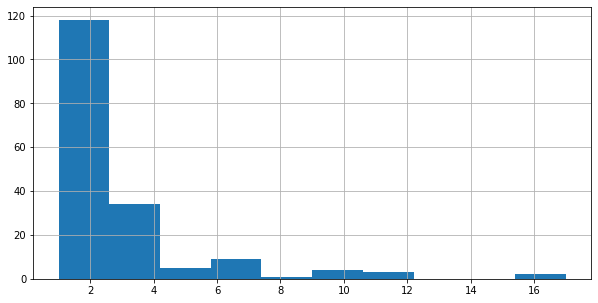

In [20]:
workitems_to_pack = pd.DataFrame(empty_blocks, columns=['CycleTime', 'LeadTime'])
workitems_to_pack["CycleTime"].hist(bins=10, figsize=(10,5))

### Q: If team reduces cycle time by 1 day, what will be the lead time for ad hoc requests?
### A:

,CycleTime,LeadTime
count,153.000000,153.000000
mean,2.986928,9.320261
std,2.738581,4.087294
min,1.000000,2.000000
25%,1.000000,7.000000
50%,2.000000,9.000000
75%,4.000000,10.000000
max,18.000000,21.000000


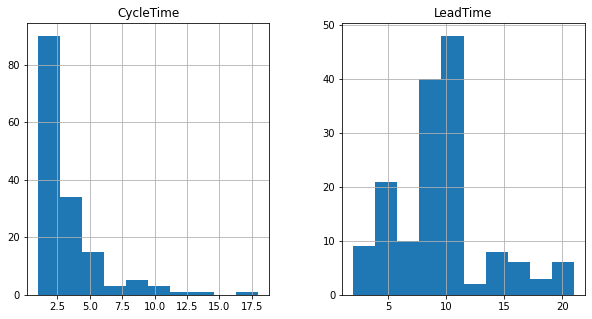

In [21]:

empty_space = original_leadtime_sum - ltdy.array_normalise_size(original_leadtime_sum, reduced_leadtime_sum)
empty_blocks = []
ltdy.create_blocks(empty_space, 0, len(empty_space), empty_blocks)

workitems_reactive = pd.DataFrame(empty_blocks, columns=['CycleTime', 'LeadTime'])
workitems_reactive.hist(bins=10, figsize=(10,5))
workitems_reactive.describe()

Unfortunately, it still seems that lead time on average would be ~10 days, however the good news is that before ad hoc request had to wait until the next Sprint. However now they can be done part of the same Sprint. 
 
### Q: If team loads less amount of work during a Sprint, how will that impact overall lead time?
### A: 

Sprint lead time profile will follow the same pattern as cycle time "reduction and shift". Meaning that work will be front-loaded leaving space at the end of the Sprint. 

### Q: If team loads less amount of work during a Sprint, what will be the lead time for ad hoc requests?
### A: 
As per above answer, Sprint work will be front-loaded meaning, this is because all team members will start on the work that is available and switch to new work when they finish their existing work. This means that ad hoc work in a Sprint it will most likely will be done at the end of the Sprint. 

### Q: Team just had an amazing/terrible Sprint does that mean team is improving/regressing? 
### A: 
TBC

[Text(0, 0.5, 'Number of work items per Sprint'), Text(0.5, 0, 'Lead Time')]

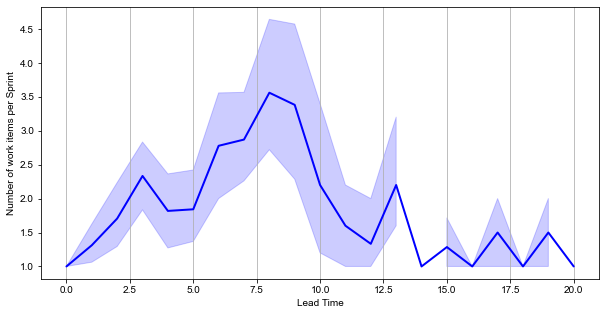

In [22]:

#monte carlo method, this will be added to the below lineplot. 
sprint_clean_simulation = np.empty([0, 2]).astype(int)
for i in range(20):
    number_of_workitems = np.random.normal(sprint_clean_workitem_count_mean, sprint_clean_workitem_count_std).astype(int)
    combinations_indicies = np.random.choice(range(0, len(sprint_clean_combinations)), number_of_workitems, p=sprint_clean_combinations_p)
    sprint_workitems = sprint_clean_combinations[combinations_indicies]
    sprint_clean_simulation = np.concatenate((sprint_clean_simulation, sprint_workitems))

sprint_agg = []
for row in sprint_clean.groupby(["Sprint", "LeadTime"]).agg({ 'LeadTime': 'count'}).itertuples():
    sprint_agg.append([row.Index[0], row.Index[1], row.LeadTime])
df_sprint_agg = pd.DataFrame(sprint_agg, columns=['Sprint','LeadTime', 'Count'])

df_sprint_agg_offset = df_sprint_agg.copy(deep=True)
df_sprint_agg_offset["LeadTime"] = df_sprint_agg_offset["LeadTime"]-1

f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid", palette="bright")
sns.lineplot(data=df_sprint_agg_offset, color="blue", linewidth=2, x="LeadTime", y="Count")
ax.xaxis.grid(True)
ax.set(ylabel="Number of work items per Sprint", xlabel="Lead Time")


### Q: How would an "ideal" Sprint look like?
### A: 
TBC